In [1]:
# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import os
import subprocess

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import time

In [3]:
def load_example(df_row):
    image = torchvision.io.read_image(df_row['image_path'])
    
    result = {
        'image': image,
        'class': df_row['Class']
    }
    return result

In [4]:
class HiddenDataset(Dataset):
    def __init__(self, split='train'):
        super().__init__()
        self.examples = []
        if split == 'val':
            df = pd.read_csv(f'FashionMNIST/{split}_mini.csv')
        else:
            df = pd.read_csv(f'FashionMNIST/{split}_mini.csv')
        df['image_path'] = df['Image_File'].apply(
            lambda x: os.path.join('FashionMNIST/train/', x))
        df = df.sort_values(by='image_path')
        df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
        if len(self.examples) == 0:
            raise ValueError('No examples.')

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']
        image = image.to(torch.float32)
        example['image'] = image
        return example

In [5]:
def get_dataset(batch_size , aug = True):
    train_ds = HiddenDataset(split='train')
    retain_ds = HiddenDataset(split='retain')
    forget_ds = HiddenDataset(split='forget')

    retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
    forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    return retain_loader, forget_loader, train_loader

In [6]:
retain_loader, forget_loader, train_loader = get_dataset(1 , True)

### No Training

In [7]:
model = resnet18(weights=None, num_classes=10)

In [8]:
def t_sne_plot(model , dataloader , title = ""):
    embeddings = []
    labels = []
    for sample in dataloader:
        image = sample['image']
        label = sample['class']
        image = torch.cat((image, image, image), dim=1)
        with torch.no_grad():
            model.eval()
            embedding = model(image)
        embeddings.append(embedding)
        labels.append(label)

    embeddings = torch.cat(embeddings, dim=0)

    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns

    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    labels = torch.cat(labels, dim=0)
    labels = labels.numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    path = "posterimgs/" + title + ".png"
    plt.savefig(path)
    plt.show()

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


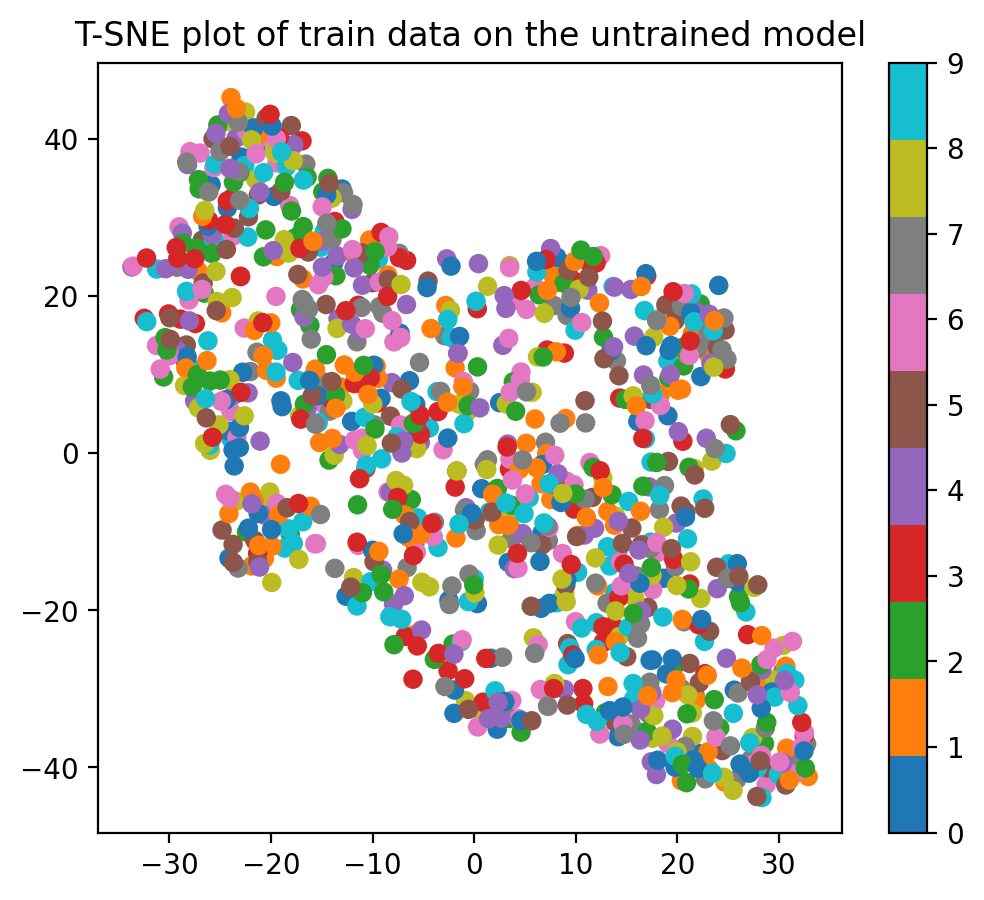

In [9]:
t_sne_plot(model , train_loader , "T-SNE plot of train data on the untrained model")

### Trained model

In [10]:
original_net = resnet18(weights=None, num_classes=10)
original_net.load_state_dict(torch.load('learned_resnet.pth'))

<All keys matched successfully>

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


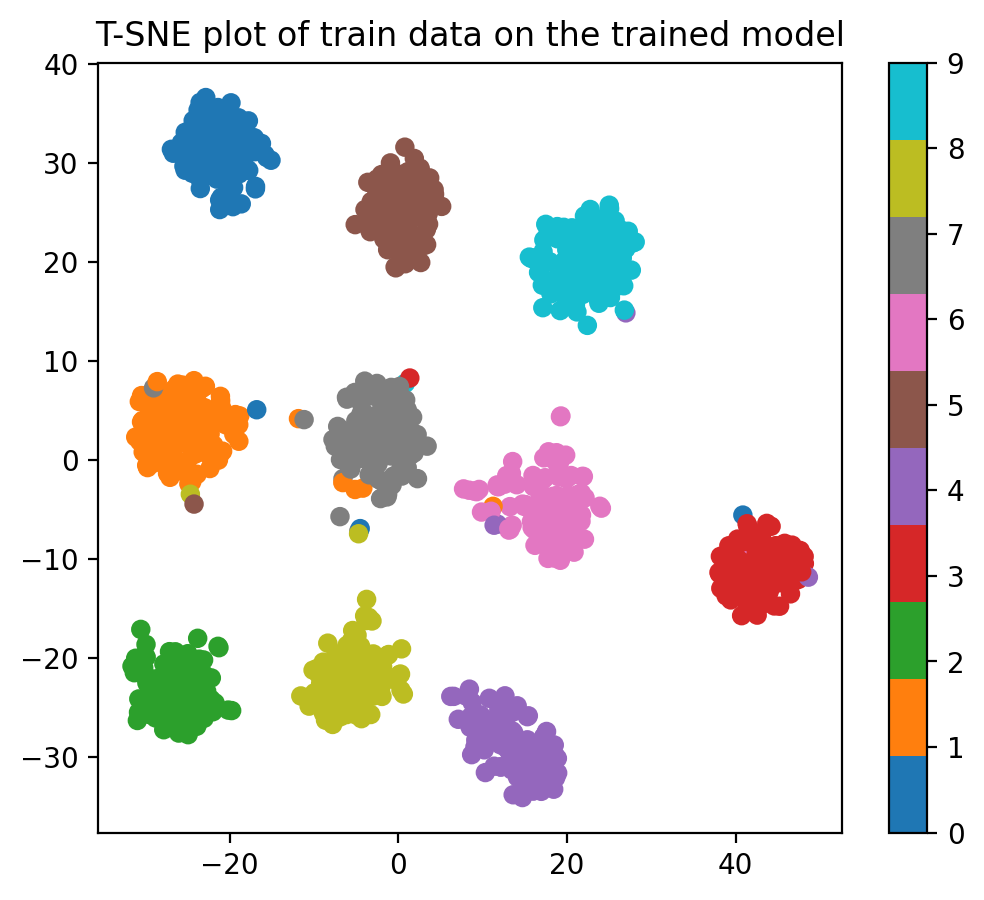

In [11]:
t_sne_plot(original_net , train_loader , "T-SNE plot of train data on the trained model")

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


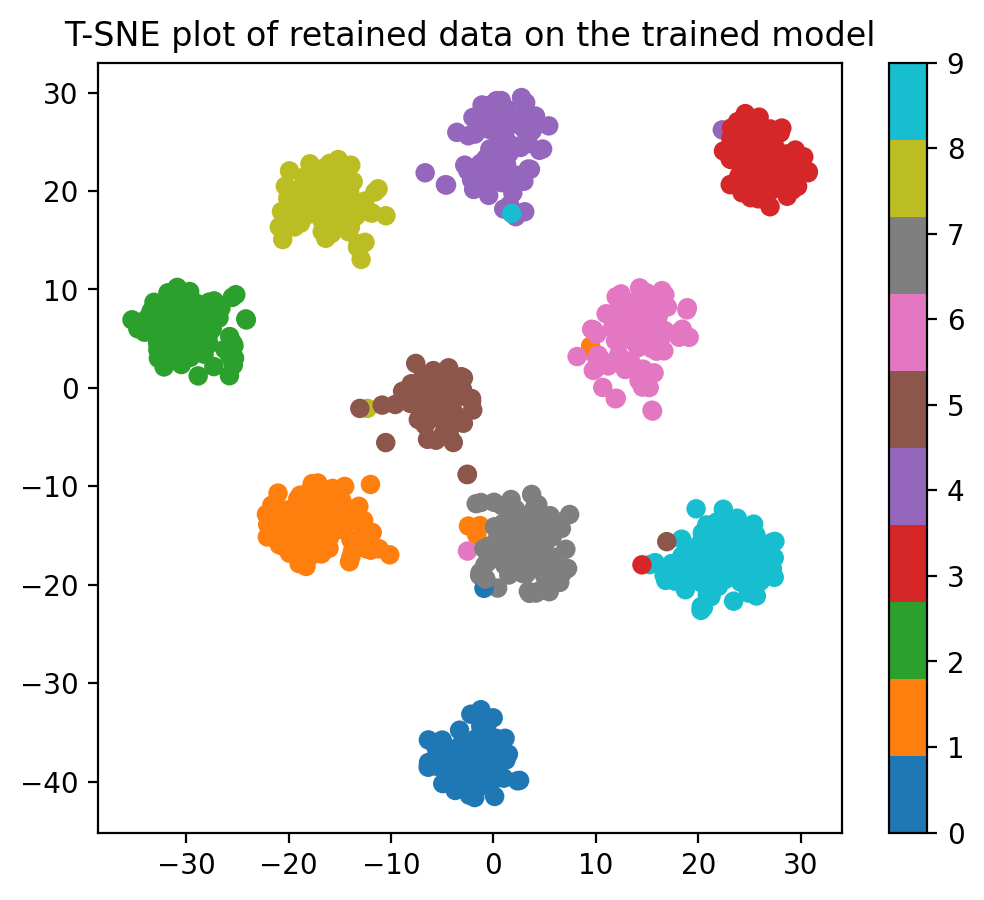

In [12]:
t_sne_plot(original_net , retain_loader , "T-SNE plot of retained data on the trained model")

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


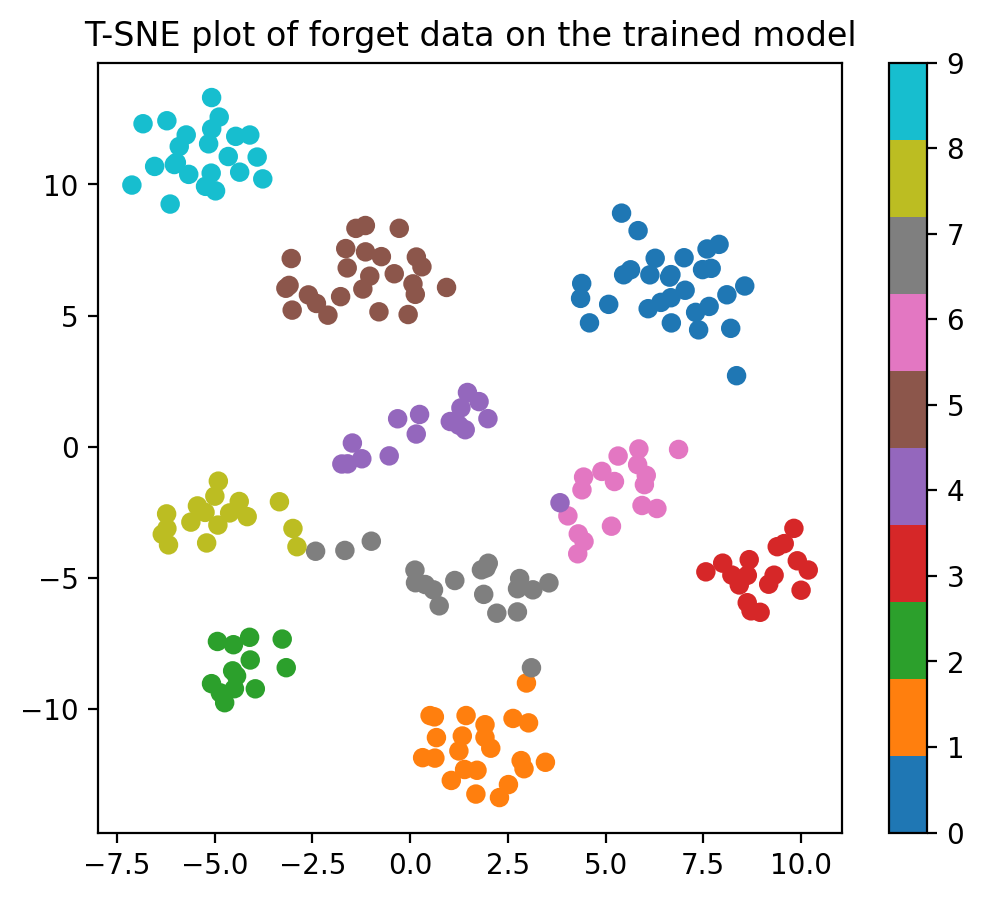

In [13]:
t_sne_plot(original_net , forget_loader , "T-SNE plot of forget data on the trained model")

### Unlearned model

In [14]:
unleaned_net = resnet18(weights=None, num_classes=10)
unleaned_net.load_state_dict(torch.load('unlearned_resnet_resetting_layer.pth'))

<All keys matched successfully>

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


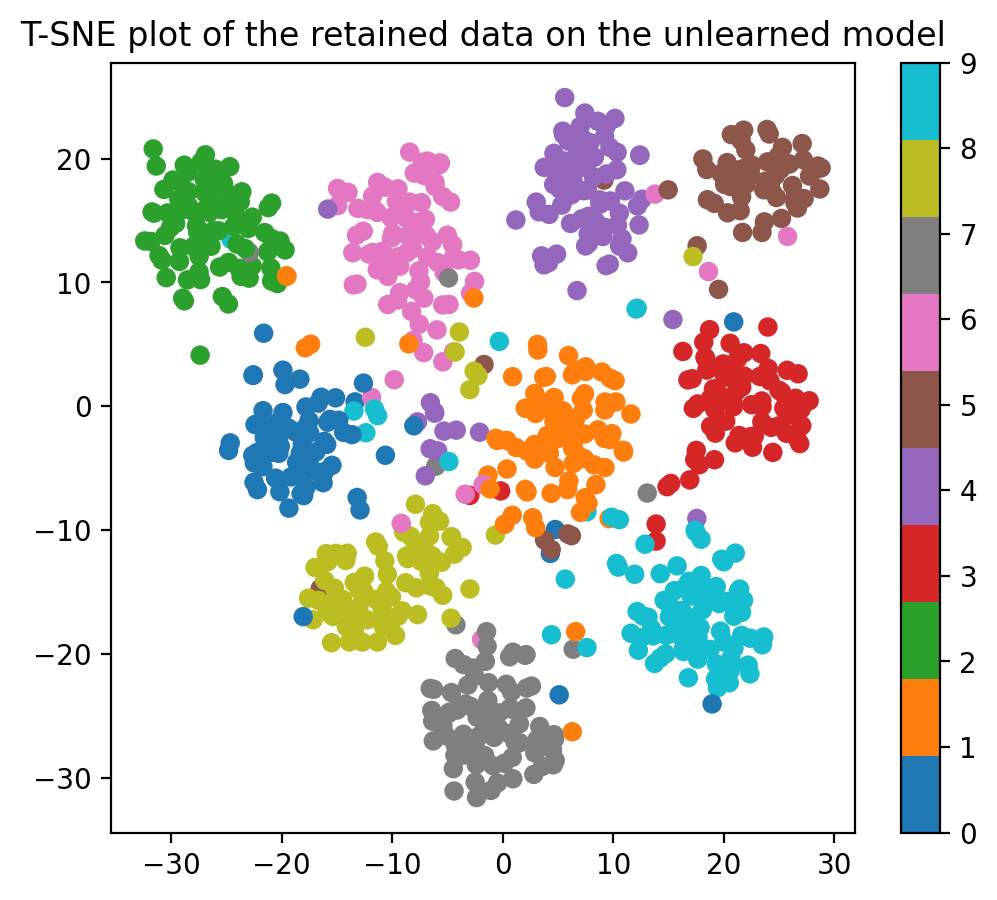

In [15]:
t_sne_plot(unleaned_net , retain_loader , "T-SNE plot of the retained data on the unlearned model")

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


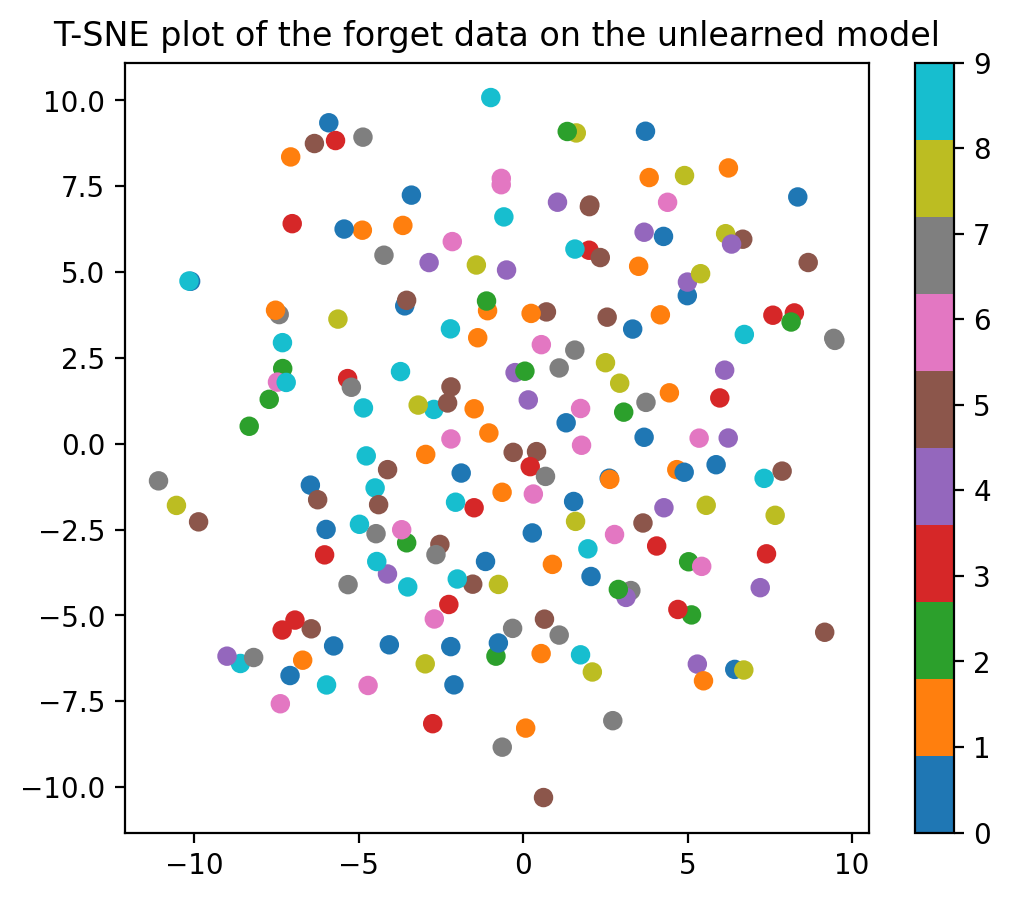

In [16]:
t_sne_plot(unleaned_net , forget_loader , "T-SNE plot of the forget data on the unlearned model")

### Comparision

In [17]:
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(torch.load('learned_resnet.pth'))

<All keys matched successfully>

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


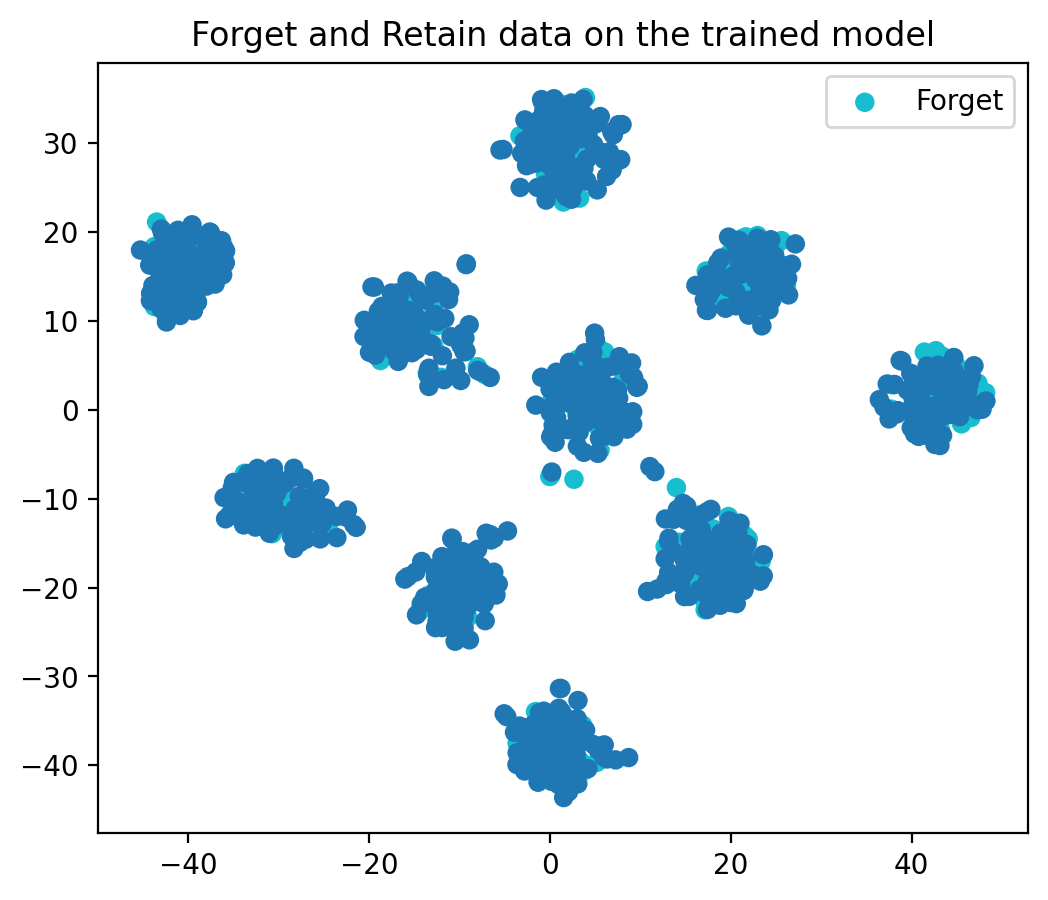

In [18]:
embeddings_forget = []

for sample in forget_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model.eval()
        embedding = model(image)
    embeddings_forget.append(embedding)

embeddings_f = torch.cat(embeddings_forget, dim=0)

embeddings_retain = []

for sample in retain_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model.eval()
        embedding = model(image)
    embeddings_retain.append(embedding)

embeddings_r = torch.cat(embeddings_retain, dim=0)

labels_forget = torch.tensor([1 for i in range(len(embeddings_f))])
labels_retain = torch.tensor([0 for i in range(len(embeddings_r))])

total_embeddings = torch.cat((embeddings_f , embeddings_r) , dim = 0)
total_labels = torch.cat((labels_forget , labels_retain) , dim = 0)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(total_embeddings)
labels = total_labels.numpy()

plt.figure(figsize=(6, 5))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels , cmap='tab10')
plt.legend(["Forget" , "Retain"])
plt.title("Forget and Retain data on the trained model")
plt.show()

In [19]:
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(torch.load('unlearned_resnet_resetting_layer.pth'))

<All keys matched successfully>

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


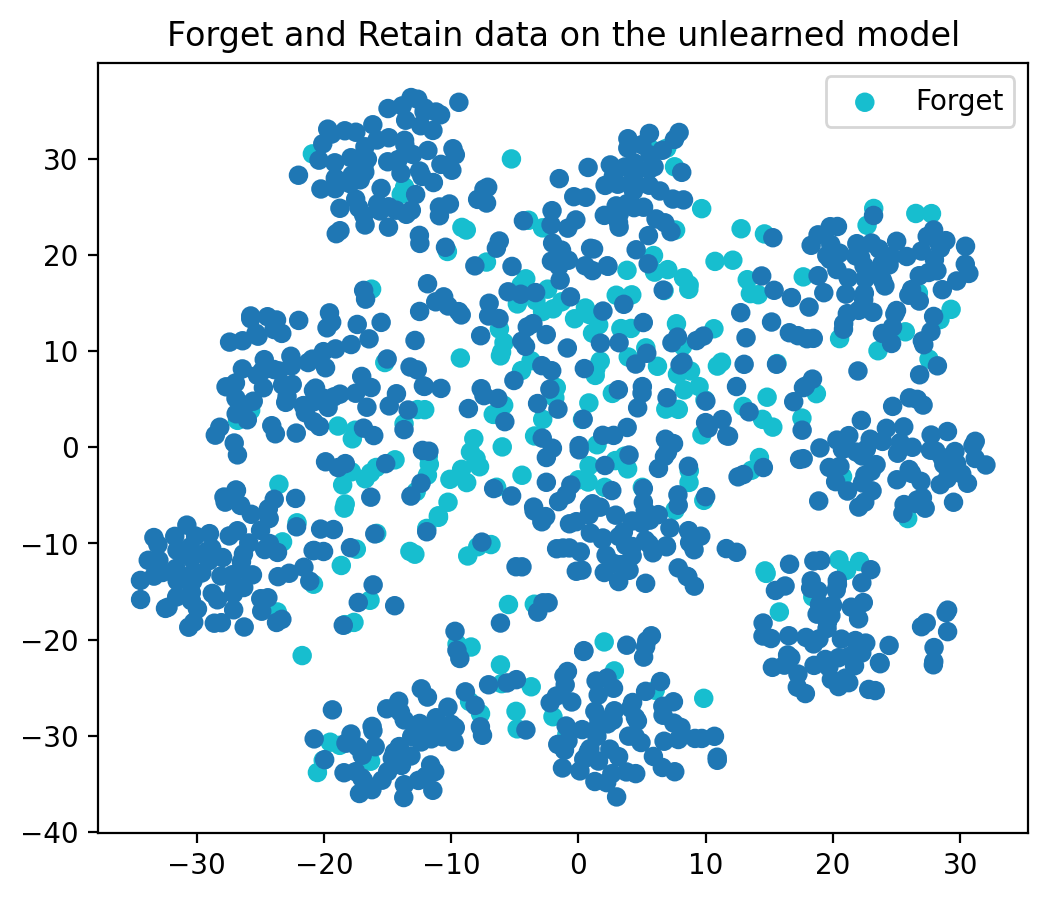

In [20]:
embeddings_forget = []

for sample in forget_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model.eval()
        embedding = model(image)
    embeddings_forget.append(embedding)

embeddings_f = torch.cat(embeddings_forget, dim=0)

embeddings_retain = []

for sample in retain_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model.eval()
        embedding = model(image)
    embeddings_retain.append(embedding)

embeddings_r = torch.cat(embeddings_retain, dim=0)

labels_forget = torch.tensor([1 for i in range(len(embeddings_f))])
labels_retain = torch.tensor([0 for i in range(len(embeddings_r))])

total_embeddings = torch.cat((embeddings_f , embeddings_r) , dim = 0)
total_labels = torch.cat((labels_forget , labels_retain) , dim = 0)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(total_embeddings)
labels = total_labels.numpy()

plt.figure(figsize=(6, 5))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels , cmap='tab10')
plt.legend(["Forget" , "Retain"])
plt.title("Forget and Retain data on the unlearned model")
plt.show()

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


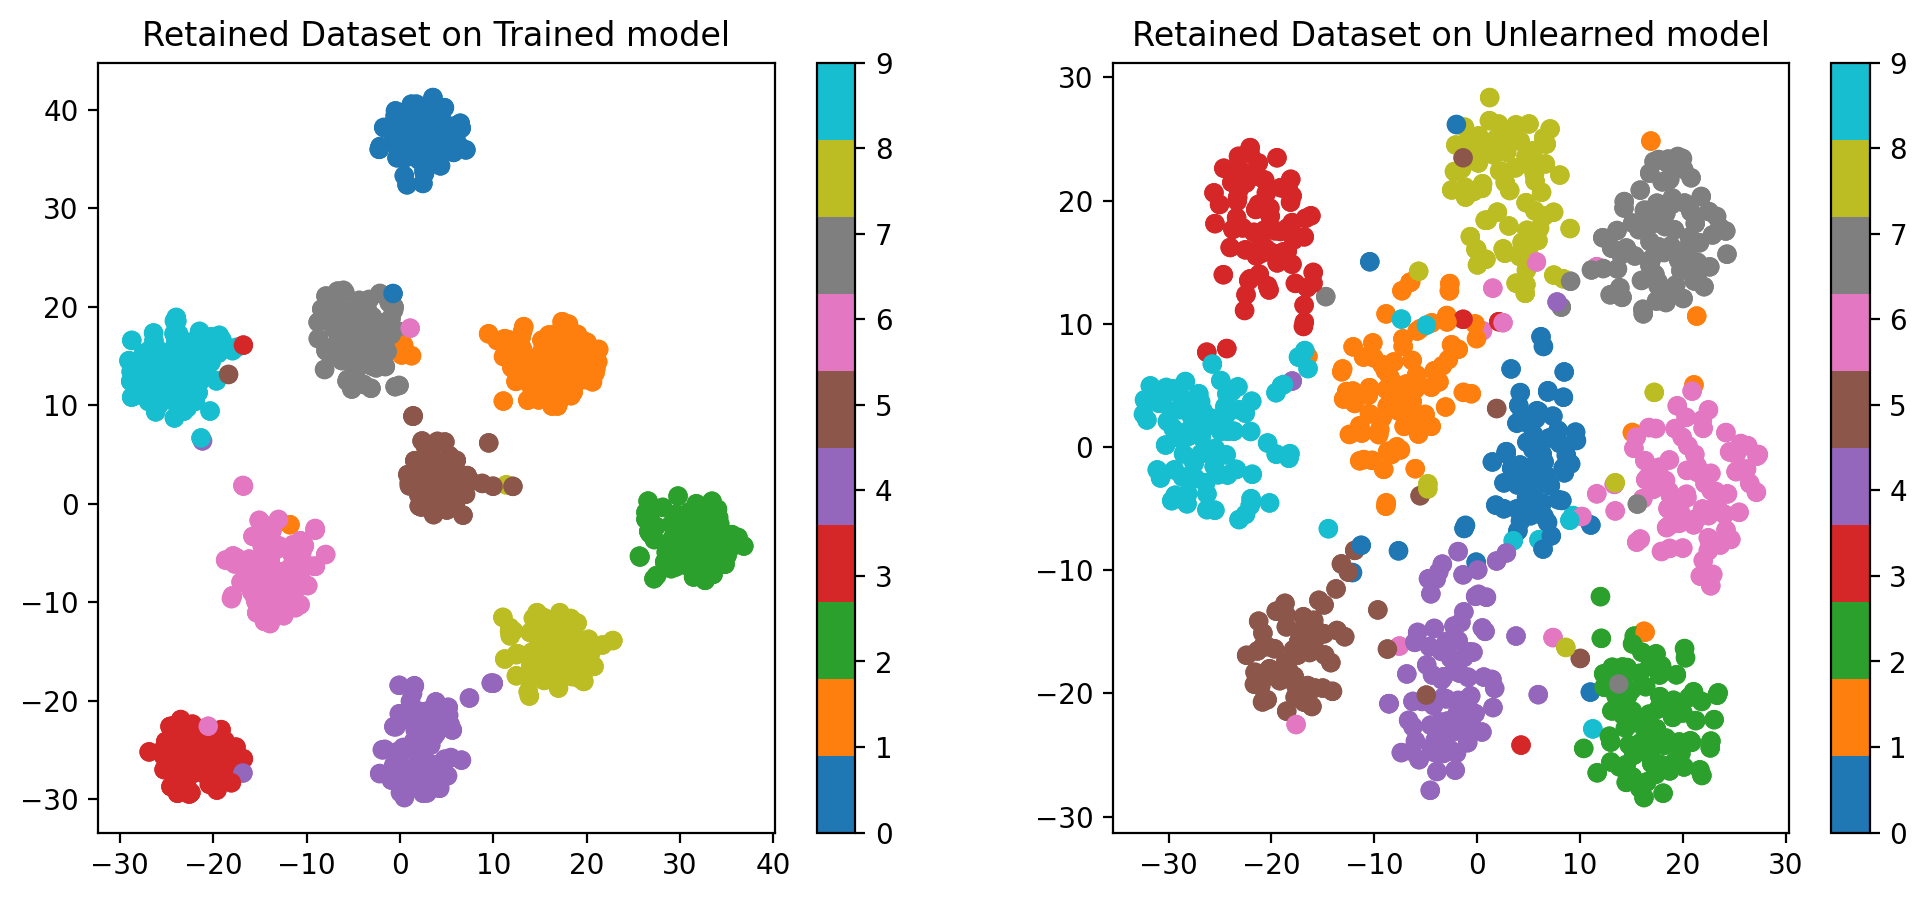

In [21]:
model_train = resnet18(weights=None, num_classes=10)
model_train.load_state_dict(torch.load('learned_resnet.pth'))
model_unlearned = resnet18(weights=None, num_classes=10)
model_unlearned.load_state_dict(torch.load('unlearned_resnet_resetting_layer.pth'))

embeddings_trained = []
labels_trained = []
for sample in retain_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model_train.eval()
        embedding = model_train(image)
    embeddings_trained.append(embedding)
    labels_trained.append(label)

embeddings_t = torch.cat(embeddings_trained, dim=0)

embeddings_unlearned = []
labels_unlearned = []
for sample in retain_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model_unlearned.eval()
        embedding = model_unlearned(image)
    embeddings_unlearned.append(embedding)
    labels_unlearned.append(label)

embeddings_u = torch.cat(embeddings_unlearned, dim=0)

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_trained = tsne.fit_transform(embeddings_t)
embeddings_2d_unlearned = tsne.fit_transform(embeddings_u)

labels_trained = torch.cat(labels_trained, dim=0)
labels_unlearned = torch.cat(labels_unlearned, dim=0)
labels_trained = labels_trained.numpy()
labels_unlearned = labels_unlearned.numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(embeddings_2d_trained[:, 0], embeddings_2d_trained[:, 1], c=labels_trained, cmap='tab10')
axs[0].set_title("Retained Dataset on Trained model")
axs[1].scatter(embeddings_2d_unlearned[:, 0], embeddings_2d_unlearned[:, 1], c=labels_unlearned, cmap='tab10')
axs[1].set_title("Retained Dataset on Unlearned model")

# Add color bar
fig.colorbar(axs[0].scatter(embeddings_2d_trained[:, 0], embeddings_2d_trained[:, 1], c=labels_trained, cmap='tab10'), ax=axs[0])
fig.colorbar(axs[1].scatter(embeddings_2d_unlearned[:, 0], embeddings_2d_unlearned[:, 1], c=labels_unlearned, cmap='tab10'), ax=axs[1])

plt.savefig("posterimgs/Retained Dataset on Trained and Unlearned model.png")
plt.show()

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


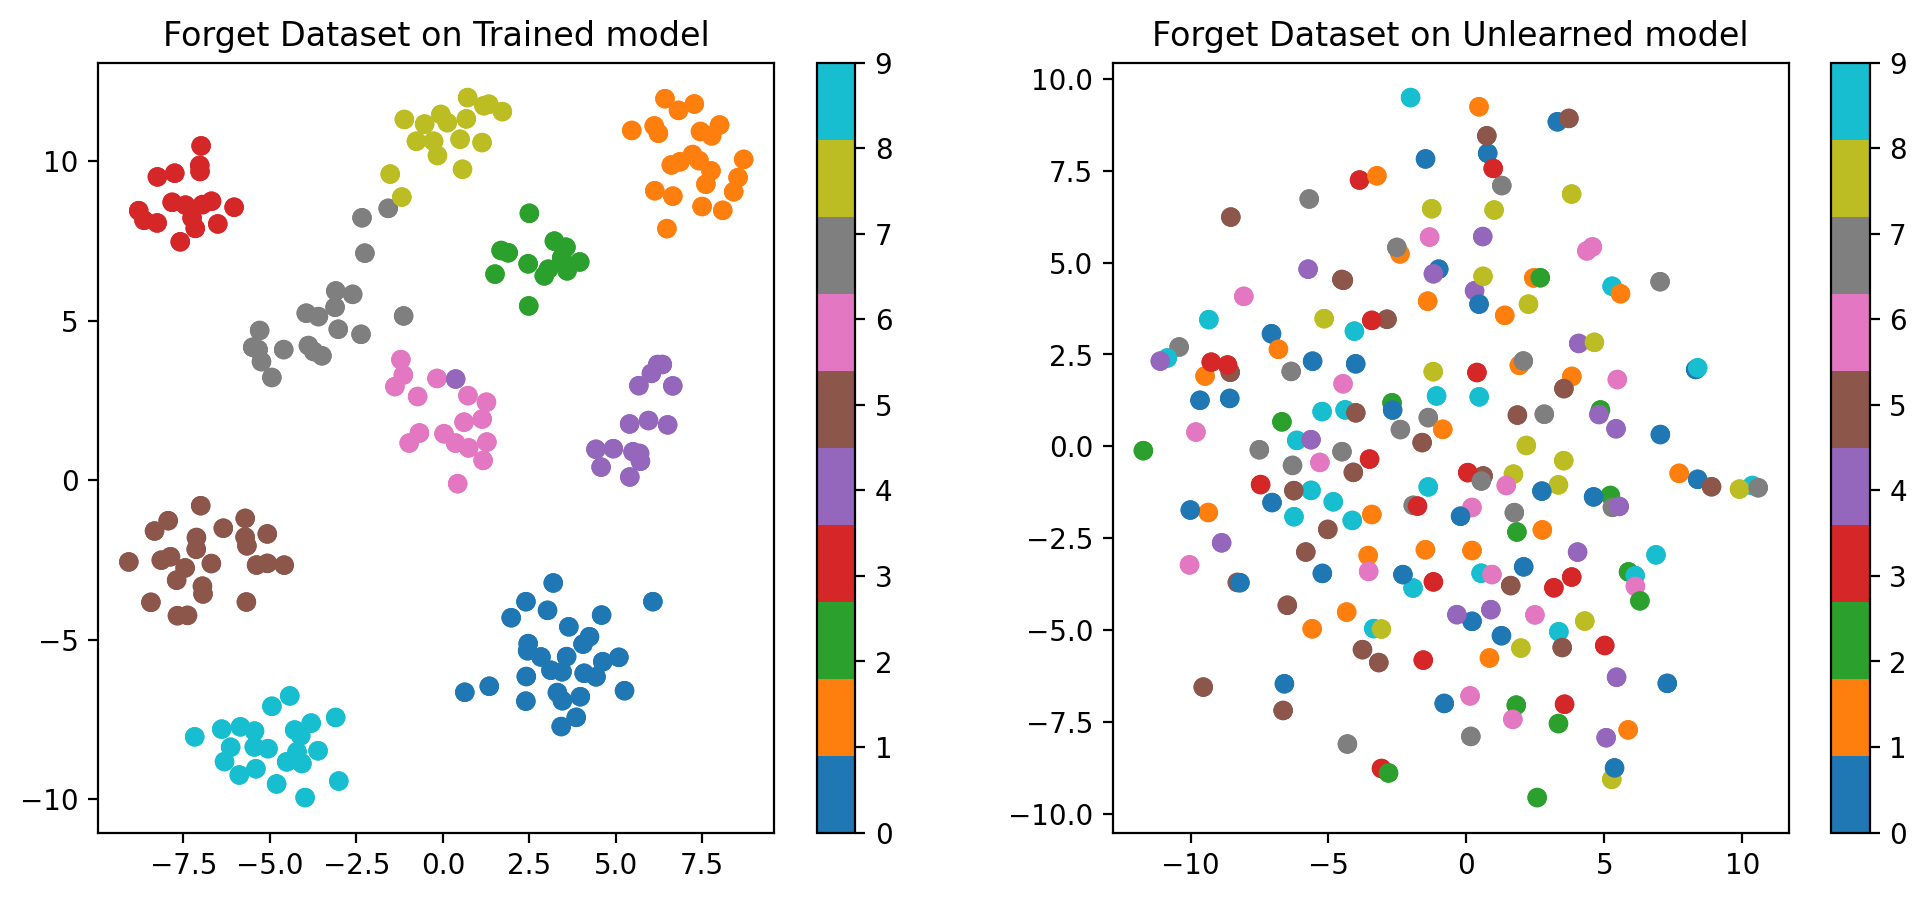

In [22]:
model_train = resnet18(weights=None, num_classes=10)
model_train.load_state_dict(torch.load('learned_resnet.pth'))
model_unlearned = resnet18(weights=None, num_classes=10)
model_unlearned.load_state_dict(torch.load('unlearned_resnet_resetting_layer.pth'))

embeddings_trained = []
labels_trained = []
for sample in forget_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model_train.eval()
        embedding = model_train(image)
    embeddings_trained.append(embedding)
    labels_trained.append(label)

embeddings_t = torch.cat(embeddings_trained, dim=0)

embeddings_unlearned = []
labels_unlearned = []
for sample in forget_loader:
    image = sample['image']
    label = sample['class']
    image = torch.cat((image, image, image), dim=1)
    with torch.no_grad():
        model_unlearned.eval()
        embedding = model_unlearned(image)
    embeddings_unlearned.append(embedding)
    labels_unlearned.append(label)

embeddings_u = torch.cat(embeddings_unlearned, dim=0)

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_trained = tsne.fit_transform(embeddings_t)
embeddings_2d_unlearned = tsne.fit_transform(embeddings_u)

labels_trained = torch.cat(labels_trained, dim=0)
labels_unlearned = torch.cat(labels_unlearned, dim=0)
labels_trained = labels_trained.numpy()
labels_unlearned = labels_unlearned.numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(embeddings_2d_trained[:, 0], embeddings_2d_trained[:, 1], c=labels_trained, cmap='tab10')
axs[0].set_title("Forget Dataset on Trained model")
axs[1].scatter(embeddings_2d_unlearned[:, 0], embeddings_2d_unlearned[:, 1], c=labels_unlearned, cmap='tab10')
axs[1].set_title("Forget Dataset on Unlearned model")

# Add color bar
fig.colorbar(axs[0].scatter(embeddings_2d_trained[:, 0], embeddings_2d_trained[:, 1], c=labels_trained, cmap='tab10'), ax=axs[0])
fig.colorbar(axs[1].scatter(embeddings_2d_unlearned[:, 0], embeddings_2d_unlearned[:, 1], c=labels_unlearned, cmap='tab10'), ax=axs[1])

plt.savefig("posterimgs/Forget Dataset on Trained and Unlearned model.png")
plt.show()

### Measuring distance

In [23]:
def closest_embedding_distance(model , dataloader1 , dataloader2=None):

    if dataloader2 is None:
        embedding = []
        for sample in dataloader1:
            image = sample['image']
            image = torch.cat((image, image, image), dim=1)
            with torch.no_grad():
                model.eval()
                e = model(image)
            embedding.append(e)
        embeddings = torch.cat(embedding, dim=0)
        
        from sklearn.metrics.pairwise import euclidean_distances
        distance = euclidean_distances(embeddings, embeddings)
        import numpy as np
        np.fill_diagonal(distance, float('inf'))
        return distance.min()
    
    else:
        embeddings1 = []
        for sample in dataloader1:
            image = sample['image']
            image = torch.cat((image, image, image), dim=1)
            with torch.no_grad():
                model.eval()
                embedding = model(image)
            embeddings1.append(embedding)
        embeddings1 = torch.cat(embeddings1, dim=0)

        embeddings2 = []
        for sample in dataloader2:
            image = sample['image']
            image = torch.cat((image, image, image), dim=1)
            with torch.no_grad():
                model.eval()
                embedding = model(image)
            embeddings2.append(embedding)
        embeddings2 = torch.cat(embeddings2, dim=0)

        from sklearn.metrics.pairwise import euclidean_distances
        distance = euclidean_distances(embeddings1, embeddings2)
        return distance.min()

In [24]:
model_trained = resnet18(weights=None, num_classes=10)
model_trained.load_state_dict(torch.load('learned_resnet.pth'))

dist_ret_ret = closest_embedding_distance(model_trained , retain_loader)
dist_ret_for = closest_embedding_distance(model_trained , retain_loader , forget_loader)
dist_for_for = closest_embedding_distance(model_trained , forget_loader)

print(f"Distance between the closest embeddings of the retained data on the trained model: {dist_ret_ret}")
print(f"Distance between the closest embeddings of the retained and forget data on the trained model: {dist_ret_for}")
print(f"Distance between the closest embeddings of the forget data on the trained model: {dist_for_for}")

Distance between the closest embeddings of the retained data on the trained model: 1.0962495803833008
Distance between the closest embeddings of the retained and forget data on the trained model: 1.1574134826660156
Distance between the closest embeddings of the forget data on the trained model: 1.3611427545547485


In [25]:
model_unlearned = resnet18(weights=None, num_classes=10)
model_unlearned.load_state_dict(torch.load('unlearned_resnet_resetting_layer.pth'))

dist_ret_ret = closest_embedding_distance(model_unlearned , retain_loader)
dist_ret_for = closest_embedding_distance(model_unlearned , retain_loader , forget_loader)
dist_for_for = closest_embedding_distance(model_unlearned , forget_loader)

print(f"Distance between the closest embeddings of the retained data on the unlearned model: {dist_ret_ret}")
print(f"Distance between the closest embeddings of the retained and forget data on the unlearned model: {dist_ret_for}")
print(f"Distance between the closest embeddings of the forget data on the unlearned model: {dist_for_for}")

Distance between the closest embeddings of the retained data on the unlearned model: 0.5720415115356445
Distance between the closest embeddings of the retained and forget data on the unlearned model: 0.6008550524711609
Distance between the closest embeddings of the forget data on the unlearned model: 0.8045859336853027


The above decrease of distance is perhaps due to randomness.